### The libraries needed

In [44]:
import pandas as pd
import numpy as np
from scipy import stats
import chardet

Finding the encoding of the dataset

In [45]:

with open("dataset.csv", "rb") as f:
    result = chardet.detect(f.read(100000))  # Read a chunk of the file
    print(result["encoding"])  # Print the detected encoding


Windows-1252


Loading the dataset but only some of the columns we need 


In [46]:
df=pd.read_csv("dataset.csv", encoding="Windows-1252", sep=";",usecols=[0,1,2,5,6,7,10,11,13,14,17])
df.head(100)

,id,category,title,bathrooms,bedrooms,currency,pets_allowed,price,price_type,square_feet,state
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,1.0,1.0,USD,Cats,2195.0,Monthly,542,CA
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,1.5,3.0,USD,"Cats,Dogs",1250.0,Monthly,1500,VA
2,5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,2.0,3.0,USD,NaN,1395.0,Monthly,1650,NC
3,5668639659,housing/rent/apartment,Two BR 209 Aegean Way,1.0,2.0,USD,"Cats,Dogs",1600.0,Monthly,820,CA
4,5668639374,housing/rent/apartment,One BR 4805 Marquette NE,1.0,1.0,USD,"Cats,Dogs",975.0,Monthly,624,NM
...,...,...,...,...,...,...,...,...,...,...,...
95,5668633801,housing/rent/apartment,Two BR 1917 S. 18th St.,1.0,2.0,USD,"Cats,Dogs",1015.0,Monthly,845,NE
96,5668632658,housing/rent/apartment,Three BR 7312 South 81st Street,2.0,3.0,USD,"Cats,Dogs",1495.0,Monthly,1850,NE
97,5668632537,housing/rent/apartment,One BR 4301 Grand Avenue Parkway,1.0,1.0,USD,NaN,1103.0,Monthly,652,TX
98,5668632393,housing/rent/apartment,One BR 2101 W. ANDERSON LN.,1.0,1.0,USD,NaN,1032.0,Monthly,600,TX


It seems like we have mostly monthly bills and 3 weekly bills we will make it even by multiplying the price with 4 to make it monthly, as for the monthly|weekly part i will just drop it.

In [47]:
df["price_type"].value_counts()

price_type
Monthly           99488
Weekly                3
Monthly|Weekly        1
Name: count, dtype: int64

In [48]:
df["price"]=df.apply( lambda row: row["price"]*4 if row["price_type"]=="Weekly" else row["price"],axis=1)
df["price_type"]=df.apply( lambda row: "Monthly" if row["price_type"]=="Weekly" else row["price_type"],axis=1)
df=df[df["price_type"]!= "Monthly|Weekly"]

Lets drop the NaN values for the important variables

In [49]:
df = df.dropna(subset=["price"])

In [50]:
df["square_feet"].isna().value_counts()
#it doesnt have nan values so we will not perform anything

square_feet
False    99490
Name: count, dtype: int64

Since there are a lot of data i will use the data for 4 major states: New York, Texas, California and Florida. So i will filter those:

In [51]:
df_ny=df[df["state"]=="NY"]#dataframe for new york
df_tx=df[df["state"]=="TX"]#Dataframe for Texas
df_ca=df[df["state"]=="CA"]#Dataframe for California
df_fl=df[df["state"]=="FL"]#Dataframe for Florida


### What I wanna do is make a linear regression where I take the square feet of the property as the independent variable and for the dependent variable to be the price for each of the states

Lets make the variables

In [52]:
#x will be the independent variable
x_ny=df_ny['square_feet'].values.tolist()
x_tx=df_tx['square_feet'].values.tolist()
x_ca=df_ca['square_feet'].values.tolist()
x_fl=df_fl['square_feet'].values.tolist()
#y will be the dependent variable
y_ny=df_ny['price'].values.tolist()
y_tx=df_tx['price'].values.tolist()
y_ca=df_ca['price'].values.tolist()
y_fl=df_fl['price'].values.tolist()

Now creating the Linear regression stats

In [53]:
slope_ny, intercept_ny, r_ny, p_ny, std_err_ny = stats.linregress(x_ny, y_ny)
slope_tx, intercept_tx, r_tx, p_tx, std_err_tx = stats.linregress(x_tx, y_tx)
slope_ca, intercept_ca, r_ca, p_ca, std_err_ca = stats.linregress(x_ca, y_ca)
slope_fl, intercept_fl, r_fl, p_fl, std_err_fl = stats.linregress(x_fl, y_fl)

The functions of the Regression lines will be:

In [54]:
def ref_func_ny(x):
    return slope_ny*x+intercept_ny

def ref_func_tx(x):
    return slope_tx*x+intercept_tx

def ref_func_ca(x):
    return slope_ca*x+intercept_ca

def ref_func_fl(x):
    return slope_fl*x+intercept_fl

Lets print the important findings that will be used in Power BI visualisations

In [55]:
print(slope_ny,intercept_ny,p_ny,std_err_ny)
print(slope_tx,intercept_tx,p_tx,std_err_tx)
print(slope_ca,intercept_ca,p_ca,std_err_ca)
print(slope_fl,intercept_fl,p_fl,std_err_fl)

0.2182635082421261 2377.9517777205097 2.4388301279374208e-05 0.05134658375275616
0.7841285775092612 508.9743419683962 0.0 0.00944223002037154
2.2569284293494105 374.58292819466715 0.0 0.0291989120513961
1.3770875899050876 137.21566033206113 0.0 0.026814904642868426


Lets save the cleaned dataset so we can use it in Power BI

In [56]:
df.to_csv("cleaned_dataset.csv")

In [57]:
correlation= df_fl["square_feet"].corr(df_fl["price"])
correlation

np.float64(0.5600534419377347)

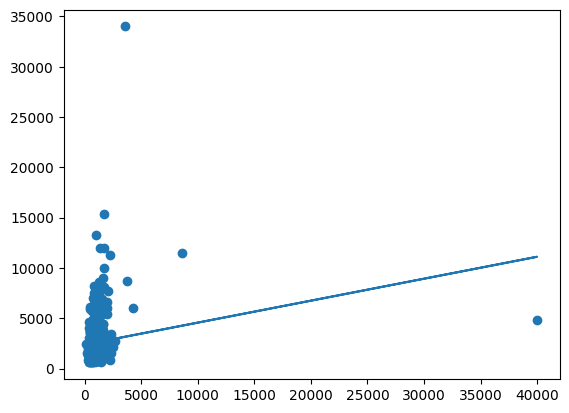

In [61]:
import matplotlib.pyplot as plt
mymodel=list(map(ref_func_ny,x_ny))
plt.scatter(x=x_ny,y=y_ny)
plt.plot(x_ny,mymodel)
plt.show()

In [59]:
df_ny[df_ny["square_feet"]==3600]

,id,category,title,bathrooms,bedrooms,currency,pets_allowed,price,price_type,square_feet,state
49908,5518370229,housing/rent/apartment,"Beautiful, Private and Convenient in Nw Woods",4.0,4.0,USD,NaN,34000.0,Monthly,3600,NY


In [60]:
df_ny["square_feet"].min()

np.int64(130)